# Embedded ML Lab - Excercise 2- Quantization

In this exercise, we will explore quantization with PyTorch. Quantization in PyTorch is fairly new introduced, consequently not all APIs are already stable, and not all operations are already supported. Also, quantization right now only works on the cpu, not on the gpu.

We will do the following things in the quantization exercise.
* First, we will play around with quantized tensors, and very common patterns in PyTorch we require later  
* In this lab, the unquantized network is already given, but we require a quantized version of the network
* To evaluate the benefits of quantization we require two things:
    * First, we are interested in the execution time of the quantized network and the speed improvements
    * Second, we are interested in how much accuracy we lose through quantization

For this lab, the network is already implemented in `net.py`, take a look at it.

In [24]:
from net import CifarNet

In [2]:
net = CifarNet()

This time we will work with a slightly more complex dataset, called CIFAR (CIFAR10) https://www.cs.toronto.edu/~kriz/cifar.html where each sample contains 3 input channels (RGB), and 32 by 32 pixels. There are 10 different types of classes, namely:
- airplane 										
- automobile 										
- bird 										
- cat 										
- deer 										
- dog 										
- frog 										
- horse 										
- ship 										
- truck

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
tf = transforms.Compose([transforms.ToTensor()])
trainloader = torch.utils.data.DataLoader(torchvision.datasets.CIFAR10('data/', train=True, download=True, transform=tf), batch_size=64, shuffle=False)
print(f"Classes in CIFAR10 {trainloader.dataset.classes}")

Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/
Classes in CIFAR10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


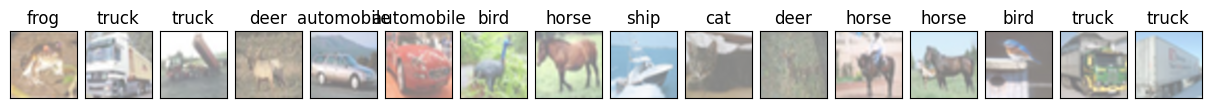

In [4]:
_, (cifar_samples, targets) = next(enumerate(trainloader))
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=16, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []}, constrained_layout=True)

for idx, ax in enumerate(axs.flat):
    ax.imshow(cifar_samples[idx,:,:,:].permute(1,2,0).numpy()*0.5 + 0.5, interpolation='spline16')
    ax.set_title(trainloader.dataset.classes[targets[idx]])
plt.show()

**Now we focus on quantized operators:**  
A normal float tensor can be quantized using `torch.quantize_per_tensor(input, scale, zero_point, dtype)` where we have to define a *scale*, a *zero_point*, and a datatype.  
Currently, PyTorch requires all `weights` to be of datatype `torch.qint8`, therefore we use a zero point of `0`, to have the same resolution in positive and negative range.   
Activations are of type `torch.quint8`. It is recommended to set the scale for these to `64` to have one bit as safety margin for overflows.
A tensor can very easily transfered back to a float tensor using `torch.dequantize()`


In [5]:
rand_values = torch.rand(3,3)
print(f"float tensor\n{rand_values}")

qvalues = torch.quantize_per_tensor(rand_values, scale=0.1, zero_point=64, dtype=torch.quint8)

print(f"quantized tensor (uint8)\n{qvalues}")

res = torch.dequantize(qvalues)

float tensor
tensor([[0.8296, 0.2987, 0.6162],
        [0.9189, 0.4903, 0.1473],
        [0.2533, 0.4767, 0.0046]])
quantized tensor (uint8)
tensor([[0.8000, 0.3000, 0.6000],
        [0.9000, 0.5000, 0.1000],
        [0.3000, 0.5000, 0.0000]], size=(3, 3), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.1, zero_point=64)


A quantized tensor when printed is transfered back to float using scale and zero_point. Each quantized tensor's scale and zero_point can be accessed by using `tensor.q_scale()` and `tensor.q_zero_point()`.

In [6]:
print(f"Tensor scale: {qvalues.q_scale()}, zero_point= {qvalues.q_zero_point()}")

Tensor scale: 0.1, zero_point= 64


Right now, we have chosen an arbitrary scale of 0.1 where we can clearly see that we were losing some precision.
In general, the quantization is done as following $$Q(\text{x},\text{scale},\text{zero_point}) = round(\frac{x}{\text{scale}} + \text{zero_point})$$
For this exercise, we do the scale calulation like following:  
* The quantized range should be symmetric  
* The quantized range should allow for a safety margin of 1 bit.  

In [7]:
def tensor_scale(input):
    return float(2*torch.max(torch.abs(torch.max(input)), torch.abs(torch.min(input))))/127.0

In [8]:
scale = tensor_scale(rand_values)
print(scale)
qvalues = torch.quantize_per_tensor(rand_values, scale=scale, zero_point=64, dtype=torch.quint8)
print(qvalues)

0.014470524675264133
tensor([[0.8248, 0.3039, 0.6222],
        [0.9261, 0.4920, 0.1447],
        [0.2605, 0.4775, 0.0000]], size=(3, 3), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.014470524675264133,
       zero_point=64)


Currently, not all operations are available as "quantized" one.  
For example, if you try an addition of two tensors `res = qvalues + qvalues` you will get an error message, that appears if you try to put quantized tensors into non-quantized operators

```
Could not run 'aten::add.Tensor' with arguments from the 'QuantizedCPU' backend. 'aten::add.Tensor' is only available for these backends: [CPU, MkldnnCPU, SparseCPU, Meta, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].
```
Luckily, for this lab all required operators exists as quantized ones. Every quantized operator additionally requires an output scale, and an output zero_point.


In [9]:
res = torch.ops.quantized.add(qvalues, qvalues, scale=0.1, zero_point=64)

As a small warm up task, we execute a quantized addition:  
**Your Task**:  
* Create two random float tensors `a` and `b` of size 100x100 ( use `torch.rand`)   
* For each tensor, calculate the tensor's scale using the provided `tensor_scale` function
* Calculate the addition in float (result `c`)
* Calculate the tensor scale of the result
* Now, we quantize the tensors `a` and `b` using the calculated scale
* Calculate the quantized addition using the function from above and plug in the output scale (scale of tensor 'c')
* Print the quantized result and the float result. Can you splot the loss in precision?


In [23]:
#-to-be-done- by student 
a = torch.rand(100, 100)
b = torch.rand(100, 100)
print("a:\t{}\nb:\t{}".format(a, b))

a_scale = tensor_scale(a)
b_scale = tensor_scale(b)
print("a_scale:\t{}\nb_scale:\t{}".format(a_scale, b_scale))

c = a + b
print("c:\t{}".format(c))

c_scale = tensor_scale(c)
print("c_scale:\t{}".format(c_scale))

a_q = torch.quantize_per_tensor(a, scale=a_scale, zero_point=64, dtype=torch.quint8)
b_q = torch.quantize_per_tensor(b, scale=b_scale, zero_point=64, dtype=torch.quint8)
print("a_q:\t{}\nb_q:\t{}".format(a_q, b_q))

c_q = torch.ops.quantized.add(a_q, b_q, scale=c_scale, zero_point=64)
c_qd = torch.dequantize(c_q)
print("c_q:\t{}".format(c_q))
print("c_qd:\t{}".format(c_qd))
###
#-to-be-done- by student 

a:	tensor([[0.6944, 0.7166, 0.9009,  ..., 0.9456, 0.8933, 0.9304],
        [0.9003, 0.3171, 0.0775,  ..., 0.2707, 0.5196, 0.4681],
        [0.5947, 0.6483, 0.2124,  ..., 0.9970, 0.4034, 0.8936],
        ...,
        [0.8718, 0.0644, 0.6947,  ..., 0.5907, 0.1195, 0.7141],
        [0.2014, 0.0505, 0.1230,  ..., 0.6420, 0.4015, 0.7617],
        [0.0721, 0.0068, 0.8354,  ..., 0.6558, 0.0209, 0.7662]])
b:	tensor([[0.0015, 0.1820, 0.8495,  ..., 0.3922, 0.3794, 0.3263],
        [0.3283, 0.6951, 0.2528,  ..., 0.3190, 0.4678, 0.6073],
        [0.9297, 0.9713, 0.7903,  ..., 0.3451, 0.1785, 0.3466],
        ...,
        [0.1591, 0.0877, 0.3173,  ..., 0.3231, 0.6361, 0.7533],
        [0.0372, 0.8250, 0.1648,  ..., 0.5430, 0.7029, 0.7314],
        [0.9783, 0.0366, 0.0572,  ..., 0.9077, 0.1925, 0.9061]])
a_scale:	0.015747338768065444
b_scale:	0.01574742700171283
c:	tensor([[0.6959, 0.8987, 1.7503,  ..., 1.3378, 1.2728, 1.2567],
        [1.2286, 1.0122, 0.3304,  ..., 0.5897, 0.9874, 1.0753],
        